[![image-3.png](https://i.postimg.cc/DwGX681Q/image-3.png)](https://postimg.cc/QFXCxN4V)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:30px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Определение стоимости автомобиля по VIN-коду</p>


</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 

    

__Постановка задачи:__ используя регулярные выражения в качестве инструмента первичной обработки и получения данных, построить модель для отределения стоимости осмомобилей марки Ford.
    
__Описание данных:__ текстовый документ в формате `.txt` c VIN-кодами североамериканских машин
    

__Оценка результата:__ Root Mean Squared Error, RMSE
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import sqrt
import warnings

from catboost import CatBoostRegressor, Pool, cv

# константы
RANDOM_SEED = 42
BASE_PATH = 'data/' # корневая директория

# настройки блокнота
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка и общая информация данных

</div>

In [2]:
with open(os.path.join(BASE_PATH, 'vin_ford_train.txt')) as t:
    txt = t.read()
    
display(txt[:200])

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMD'

__Структура данных:__ каждая запись в квадратных скобках представляет собой 17-ти значний vin код, двоеточие, после которого укажана цена. Также известно что данные автомобили из северной америки и произведены компанией Ford.

__Структура vin-кода:__

[![2024-04-20-17-43-28.jpg](https://i.postimg.cc/g203mWHR/2024-04-20-17-43-28.jpg)](https://postimg.cc/XpTrkth7)

__Расшифровка wmi-кода автомобилей Ford:__

In [3]:
ford_wmi = {
    'AFA': 'Ford Motor Company of Southern Africa & Samcor',
    'AFB': 'Mazda BT-50 made by Ford Motor Company of Southern Africa',
    'JC0': 'Ford brand cars made by Mazda',
    'JC2': 'Ford Courier made by Mazda',
    'KNJ': 'Ford Festiva & Aspire made by Kia',
    'LJX': 'JMC Ford',
    'LVS': 'Changan Ford & Changan Ford Mazda',
    'MAJ': 'Ford India',
    'MNB': 'Ford Thailand',
    'NM0': 'Ford Otosan',
    'PE1': 'Ford Motor Company Philippines',
    'PE3': 'Mazda Philippines made by Ford Motor Company Philippines',
    'PR8': 'Ford',
    'LFA': 'Ford Lio Ho Motor Co Ltd. old designation',
    'RHA': 'Ford Lio Ho Motor Co Ltd. new designation',
    'RL0': 'Ford Vietnam',
    'SBC': 'Iveco Ford Truck',
    'SFA': 'Ford UK',
    'VSK': 'Nissan Motor Iberica SA, Nissan passenger car/MPV/van/SUV/pickup & Ford Maverick 1993–1999',
    'VS6': 'Ford Spain',
    'WF0': 'Ford Germany',
    'X9F': 'Ford Motor Company ZAO',
    'Z6F': 'Ford Sollers (Russia)',
    '1FA': 'Ford car',
    '1FB': 'Ford "bus" (van with more than 3 rows of seats)',
    '1FC': 'Ford stripped chassis made by Ford',
    '1FD': 'Ford incomplete vehicle',
    '1FM': 'Ford MPV/SUV',
    '1FT': 'Ford truck',
    '1F1': 'Ford SUV - Limousine (through 2009)',
    '1F6': 'Ford stripped chassis made by Detroit Chassis LLC',
    '1ZV': 'Ford made by AutoAlliance International',
    '2FA': 'Ford car',
    '2FM': 'Ford MPV/SUV',
    '2FT': 'Ford truck',
    '3FA': 'Ford car',
    '3FC': 'Ford stripped chassis made by Ford & IMMSA',
    '3FE': 'Ford Mexico',
    '3FM': 'Ford MPV/SUV',
    '3FN': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (truck)',
    '3FR': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (incomplete vehicle)',
    '3FT': 'Ford truck',
    '4F2': 'Mazda SUV made by Ford',
    '4F4': 'Mazda truck made by Ford',
    '4N2': 'Nissan Quest made by Ford',
    '5LD': 'Ford & Lincoln incomplete vehicle – limousine (2010–2014)',
    '6F1': 'Ford',
    '6FP': 'Ford Australia',
    '7A5': 'Ford New Zealand',
    '8AF': 'Ford Argentina',
    '9BF': 'Ford Brazil',
}

##  Разрешенные символы

- в коде не используются следующие символы: I, O, Q
- при кодировке года неиспользуемые символы: I, O, Q, U и Z
- последние три символа являются цифрами

In [4]:
ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]
ALLOWED_CHARS_NUM = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q', 'U', 'Z')]
ALLOWED_NUMS = [str(x) for x in range(1,10)] + ['0']

allowed = ''.join(ALLOWED_CHARS+ALLOWED_NUMS)
allowed_num = ''.join(ALLOWED_CHARS_NUM+ALLOWED_NUMS)
print(allowed)

ABCDEFGHJKLMNPRSTUVWXYZ1234567890


## Северо-Американский формат VIN

Создадим регелярное выражение для получения vin-кода и его отдельных частей, а так же цены автомобилей, учитывая разрешенные символы.

In [5]:
wmi = f'(?P<wmi>[{allowed}]{{3}})'         # 1-3
brake = f'(?P<brake>[{allowed}])'          # 4
model = f'(?P<model>[{allowed}]{{3}})'     # 5-7
engine = f'(?P<engine>[{allowed}])'        # 8
check = f'(?P<check>[{allowed}])'          # 9
year = f'(?P<year>[{allowed_num}])'        # 10
plant = f'(?P<plant>[{allowed}])'          # 11
vis = f'(?P<vis>[{allowed}]{{3}}\\d{{3}})' # 12-17

price = f'(?P<price>\d+)'                  # цена

full = f'\\b{wmi}{brake}{model}{engine}{check}{year}{plant}{vis}:{price}\\b'
data_re = re.compile(full)

In [6]:
data_re.findall(txt[:200])

[('2FM', 'D', 'K3J', 'C', '4', 'B', 'B', 'A41556', '12500'),
 ('3FA', '6', 'P0H', '7', '5', 'E', 'R', '208976', '14500'),
 ('3FA', 'H', 'P08', 'Z', '1', '7', 'R', '268380', '1300'),
 ('1FM', 'C', 'U0G', 'X', '3', 'D', 'U', 'C59421', '15200'),
 ('1FA', 'H', 'P2E', '8', '9', 'D', 'G', '119368', '11600'),
 ('1FM', '5', 'K8D', '8', '2', 'D', 'G', 'A16143', '26400'),
 ('1FT', 'F', 'W1C', 'F', 'X', 'C', 'F', 'C23663', '14000')]

##  Получение набора данных

In [7]:
def decode_txt(s: str) -> pd.DataFrame :
    return pd.DataFrame([x.groupdict() for x in data_re.finditer(s)])

In [9]:
df = decode_txt(txt)
display(df.head())

,wmi,brake,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [10]:
# общая онформакци о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   vis     71884 non-null  object
 8   price   71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


> В данных отсутствуют пропуски.

> Необходимо проверить:
> - все ли wmi-коды относятся к автомобилям Ford
> - что признак `price` содержит только числа

### проверка wmi

проверим все ли полученные wmi-коды принадлежат автомобилям марки Ford

In [11]:
if all(wmi in ford_wmi.keys() for wmi in df['wmi'].values):
    print('Все полученные wmi-кода принадлежат автомобилям марки FORD')
else:
    print('Некоторые wmi-коды не принадлежат автомобилям марки FORD')

Все полученные wmi-кода принадлежат автомобилям марки FORD


### проверка признака `price`

In [12]:
if all(price.isalnum() for price in df['price'].values):
    df['price'] = df['price'].astype(int)
    print('Все цены указаны верно')
    if df['price'].dtype == 'int64': 
        print('Тип данных признака `price` изменен: `object`->`int`')
else: 
    print('Некоторые цены указаны некорректно')

Все цены указаны верно
Тип данных признака `price` изменен: `object`->`int`


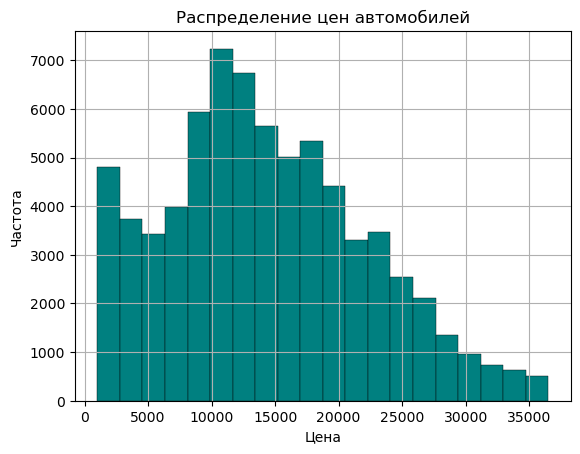

In [13]:
# гистограмма распределения цен
plt.hist(df['price'], bins=20, color='teal', edgecolor='black', linewidth=0.3)
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Распределение цен автомобилей')
plt.grid(True)
plt.show()

> Гистограмма показывает распределение цен автомобилей. Она близка к нормальному, но имеет дополнительный пик в начале, что указывает на наличие дополнительного скопления наблюдений с более низкими ценами. Это не должно сильно повлиять на качество обобщающей способности модели.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Обучение модели

</div>

## Выделение выборок для обучения и тестирования

Разделим датасет, в соотношении 80/20

In [14]:
df_train, df_test= train_test_split(df, test_size=.2, random_state=RANDOM_SEED)

In [15]:
# размер наборов данных
print(f'Размер обучающего набора: {len(df_train)/len(df):.0%}')
print(f'Размер тестового набора: {len(df_test)/len(df):.0%}')

Размер обучающего набора: 80%
Размер тестового набора: 20%


## Baseline model

Используем медианное значение для предсказания и рассчета RMSE

In [16]:
median_price = df_train['price'].median() # медиана
median_predictions = np.full_like(df_train['price'], fill_value=median_price) # предсказания
rmse_median = sqrt(mean_squared_error(df_train['price'], median_predictions)) # rmse

# результат
print(f'Среднеквадратичная ошибка (RMSE) для константной модели: {rmse_median:.2f}')

Среднеквадратичная ошибка (RMSE) для константной модели: 7862.33


> В среднем базовая модель (медианное значение) ошибается в ценах на 7862.33

## Ridge model

В качестве линейной модели используем Ridge:
- Закодируем категориальные признаки с помощью метода кодирования One-Hot (признак `check` в данном случае так же следует рассматривать как категориальный признак)
- Используем кросс-валидацию для оценки производительности модели на обучающих данных, с помощью корня из среднеквадратичной ошибки (Root Mean Squared Error, RMSE).

In [17]:
# категориальные признаки
categorical_features = [col for col in df_train.columns if col != 'price'] # категориальные признаки
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # обработчик категориальных признаков
model = Ridge() # модель

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# конвейер с предобработкой данных и моделью
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

In [19]:
# оценка модели
scores = cross_val_score(pipeline, 
                         df_train[categorical_features],
                         df_train['price'],
                         cv=5, 
                         scoring='neg_mean_squared_error')

print(f'Среднеквадратичная ошибка (RMSE) модели: {sqrt(-scores.mean()):.2f}')

Средняя ошибка (RMSE) модели: 2900.05


> В среднем линейния модель (Ridge) ошибается в ценах на 2900.05

## CatBoost model

Сравним базовую модель, с моделью градиентного бустинга.

In [28]:
# данные
train_pool = Pool(data=df_train.drop(columns=['price']),
                 label=df_train['price'], 
                 cat_features=categorical_features)

test_pool = Pool(data=df_test.drop(columns=['price']),
                 cat_features=categorical_features)

In [21]:
# параметры модел
params = {
    'learning_rate': 0.1,
    'loss_function': 'RMSE'
}

model = CatBoostRegressor(**params)

In [29]:
# оценка модели
cv_data = cv(pool=train_pool,
             params=params,
             fold_count=5,
             shuffle=True,
             partition_random_seed=42,
             verbose=False)

rmse_mean = cv_data['test-RMSE-mean'].mean()

# среднее значение RMSE
print(f'Среднеквадратичная ошибка RMSE по кросс-валидации: {rmse_mean:.2f}')

Training on fold [0/5]

bestTest = 2833.580937
bestIteration = 985

Training on fold [1/5]

bestTest = 2758.710218
bestIteration = 959

Training on fold [2/5]

bestTest = 2781.924517
bestIteration = 924

Training on fold [3/5]

bestTest = 2804.126151
bestIteration = 996

Training on fold [4/5]

bestTest = 2785.807056
bestIteration = 995

Среднее значение RMSE по кросс-валидации: 2918.22


> В среднем модель градиентного бустинга (CatBoost) ошибается в ценах на 2918.22

## Сводная таблица качества моделей

In [217]:
data = {
    'Model': ['Baseline', 'Ridge', 'CatBoost'],
    'RMSE': [7862.33, 2900.05, 2918.22]
    
}
display(pd.DataFrame(data))

,Model,RMSE
0,Baseline,7862.33
1,Ridge,2900.05
2,CatBoost,2918.22


> Результаты показывают, что как линейная модель (Ridge), так и градиентный бустинг (CatBoost) показывают схожий результат по среднеквадратичной ошибке (RMSE), который значительно превышает ошибку простой константной модели, всегда предсказывающей медиану целевой переменной.

## Итоговая модель

In [30]:
# гиперпараметры модели
parameters = {'verbose': 500,
              'eval_metric': 'RMSE',
              'iterations': 1000,
              'learning_rate': 0.1,
              'random_seed':RANDOM_SEED,
              'early_stopping_rounds': 30
             }
# модель
regressor = CatBoostRegressor(**parameters)

# обучение модели
regressor.fit(train_pool)

0:	learn: 7239.5321262	total: 14.3ms	remaining: 14.3s
500:	learn: 2759.3038717	total: 5.64s	remaining: 5.62s
999:	learn: 2686.9568691	total: 11.8s	remaining: 0us


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Проверка модели на тестовой выборке

</div>

In [34]:
# предказание данных
predict = regressor.predict(test_pool)
rmae = sqrt(mean_squared_error(df_test['price'], predict))
# вывод результатов
print(f'RMSE на тестовых данных: {rmae}')

RMSE на тестовых данных: 2785.03719892253


> Минимальное расхождение между ошибками на тестовом и тренировочном наборах данных указывает на отсутствие явного переобучения модели.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Вывод
    
</div>

Проект был направлен на практическое применение регулярных выражений для работы с VIN-кодами автомобилей. 

Регулярные выражения представляют собой мощный инструмент, который мы успешно применили для извлечения необходимой информации из текстовых данных. Это включало в себя составление шаблонов для поиска и извлечения конкретных частей VIN-кода, таких как производитель, модель и год выпуска.

Далее мы использовали полученные данные для построения модели, которая предсказывает цену автомобилей на основе их VIN-кодов. Мы применили различные алгоритмы машинного обучения, такие как Ridge регрессия и CatBoostRegressor, чтобы определить стоимость автомобилей марки Ford на основе извлеченных данных.

Результаты проекта показали, что применение регулярных выражений для обработки текстовых данных и последующего использования их в моделировании может быть очень эффективным инструментом. Дальнейшие шаги работы включают получение дополнительных данных для расшифровки VIN-кодов, что позволит улучшить точность и надежность модели, а также обогатить набор данных для более полного анализа и прогнозирования цен.
